In [23]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataload
import torchvision.transforms as transforms
import torchvision.utils as vutils

from tqdm.notebook import tqdm

# | Global variables

In [7]:
dataroot = "/kaggle/input/animefacedataset"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
G = 64
D = 64
lr = 0.0002
beta1 = 0.5
ngpu = 2

# | Load the Datasets (Train & Validation Split)

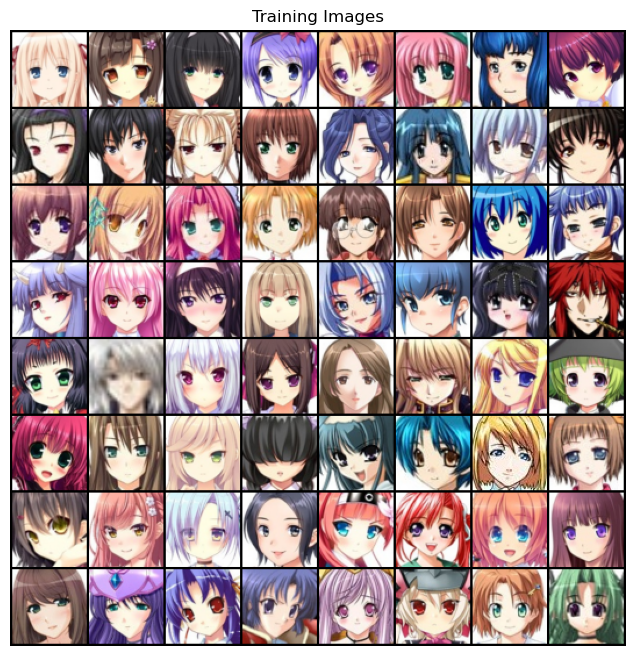

In [28]:
dataset = dataload.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

<h1>| Generator</h1>

<p style="font-size: 17px">In GAN, Generators play the role of upsampling. The generator takes as input a low-resolution image or a random noise vector and progressively upsamples it using techniques like transposed convolutions (also known as fractionally strided convolutions) or nearest-neighbor interpolation followed by convolutional layers. Upsampling allows the generator to transform low-resolution inputs into higher-resolution outputs that resemble real data.</p>

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim

        def block(in_channels, out_channels, normalize=True, ks=4, s=2, pad=1):
            layers = []
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=ks, stride=s, padding=pad, bias=False))
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, G * 8, normalize=False, s=1, pad=0),
            *block(G * 8, G * 4),
            *block(G * 4, G * 2),
            *block(G * 2, G),
            nn.ConvTranspose2d(in_channels=G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)
    
netG = Generator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

DataParallel(
  (module): Generator(
    (model): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (12): Tanh()
    )
  )
)


<h1>| Discriminator</h1>

<p style="font-size: 17px">The discriminator takes an input image (either real or generated) and processes it through convolutional layers with pooling operations such as max pooling or strided convolutions. These downsampling operations reduce the spatial dimensions of the input feature maps while increasing their depth (number of channels). Downsampling helps capture high-level features and patterns in images at different scales.</p>

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_channels, out_channels, normalize=True):
            layers=[]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(3, D, normalize=False),
            *block(D, D*2),
            *block(D*2, D*4),
            *block(D*4, D*8),
            nn.Conv2d(D*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, img):
        return self.model(img)
    
netD = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
   

# Set Optimizers and Loss Functions

In [12]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

<h1>| Train-Validation Pipeline</h1>

<p style="font-size: 17px">The Generator generates the fake image. We train the discriminator with the real images and the fake generated images. Mean of the losses found on both the steps (using BCE Loss function) gives the loss of <b>Discriminator</b>. Similar approch is done for <b>Generator</b> where we enable gradient for generator optimization and send another forwards pass to the discriminator</p>

In [31]:
img_list = []
train={
    "G_losses" : [],
    "D_losses" : [],
    "D_xs" : [],
    "D_G_z1s" : [],
    "D_G_z2s" : []
}

val={
    "G_losses" : [],
    "D_losses" : [],
    "D_xs" : [],
    "D_G_z1s" : [],
    "D_G_z2s" : []
}

iters = 0
num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    
    #TRAINING LOOP
    for i, data in enumerate(train_dataloader, 0):
        optimizerD.zero_grad()
        
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        #GENERATE FAKE IMAGE
        targets = torch.ones(batch_size, 1, device=device)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        
        #DISCRIMINATOR LOSS CALCULATION
        #REAL LOSS
        output = netD(real_data).view(-1)
        real_targets = torch.ones(real_data.size(0), 1, device=device)
        errD_real = criterion(output, real_targets.squeeze(1))
        errD_real.backward()
        D_x = output.mean().item()

        #FAKE LOSS
        fake_targets = torch.zeros(fake_data.size(0), 1, device=device)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, fake_targets.squeeze(1))
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        #DISCRIMINATOR LOSS
        errD = (errD_real + errD_fake)/2

        optimizerD.step()

        #GENERATOR LOSS CALCULATION
        optimizerG.zero_grad()
        output = netD(fake_data).view(-1)
        Gfake_targets = torch.ones_like(output)

        errG = criterion(output, Gfake_targets)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        #SAVE THE LOGS
        train["G_losses"].append(errG.item())
        train["D_losses"].append(errD.item())
        train["D_xs"].append(D_x)
        train["D_G_z1s"].append(D_G_z1)
        train["D_G_z2s"].append(D_G_z2)

    with torch.no_grad():
        #VALIDATION LOOP
        for i, data in enumerate(val_dataloader, 0):
        
            real_data = data[0].to(device)
            b_size = real_data.size(0)

            targets = torch.ones(batch_size, 1, device=device)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise)

            output = netD(real_data).view(-1)
            real_targets = torch.ones(real_data.size(0), 1, device=device)
            errD_real = criterion(output, real_targets.squeeze(1))
            D_x = output.mean().item()

            fake_targets = torch.zeros(fake_data.size(0), 1, device=device)
            output = netD(fake_data.detach()).view(-1)
            errD_fake = criterion(output, fake_targets.squeeze(1))
            D_G_z1 = output.mean().item()

            errD = (errD_real + errD_fake)/2

            output = netD(fake_data).view(-1)
            Gfake_targets = torch.ones_like(output)

            errG = criterion(output, Gfake_targets)
            D_G_z2 = output.mean().item()

            val["G_losses"].append(errG.item())
            val["D_losses"].append(errD.item())
            val["D_xs"].append(D_x)
            val["D_G_z1s"].append(D_G_z1)
            val["D_G_z2s"].append(D_G_z2)
        
    
    print('Train Logs - [Epoch %d] : G_Loss : %.4f | D_Loss : %.4f | D(x) : %.4f | D(G(z)): %.4f/%.4f'%(epoch,train["G_losses"][epoch],
                                                                                           train["D_losses"][epoch],
                                                                                           train["D_xs"][epoch],
                                                                                           train["D_G_z1s"][epoch],
                                                                                           train["D_G_z2s"][epoch]))

  0%|          | 0/30 [00:00<?, ?it/s]

Train Logs - [Epoch 0] : G_Loss : 3.7543 | D_Loss : 0.2748 | D(x) : 0.8207 | D(G(z)): 0.1936/0.0463
Train Logs - [Epoch 1] : G_Loss : 3.9565 | D_Loss : 0.1928 | D(x) : 0.8383 | D(G(z)): 0.1374/0.0412
Train Logs - [Epoch 2] : G_Loss : 4.2936 | D_Loss : 0.2826 | D(x) : 0.8180 | D(G(z)): 0.2227/0.0297
Train Logs - [Epoch 3] : G_Loss : 2.0950 | D_Loss : 0.3007 | D(x) : 0.7190 | D(G(z)): 0.1381/0.1898
Train Logs - [Epoch 4] : G_Loss : 6.6093 | D_Loss : 0.3163 | D(x) : 0.9155 | D(G(z)): 0.3279/0.0031
Train Logs - [Epoch 5] : G_Loss : 0.8397 | D_Loss : 0.4929 | D(x) : 0.5189 | D(G(z)): 0.0223/0.5146
Train Logs - [Epoch 6] : G_Loss : 7.4367 | D_Loss : 0.6178 | D(x) : 0.9875 | D(G(z)): 0.5947/0.0015
Train Logs - [Epoch 7] : G_Loss : 4.6101 | D_Loss : 0.3895 | D(x) : 0.5616 | D(G(z)): 0.0134/0.0315
Train Logs - [Epoch 8] : G_Loss : 3.1444 | D_Loss : 0.0749 | D(x) : 0.9286 | D(G(z)): 0.0609/0.0875
Train Logs - [Epoch 9] : G_Loss : 6.4426 | D_Loss : 0.2785 | D(x) : 0.9786 | D(G(z)): 0.3267/0.0049


<h1>| Visualize</h1>

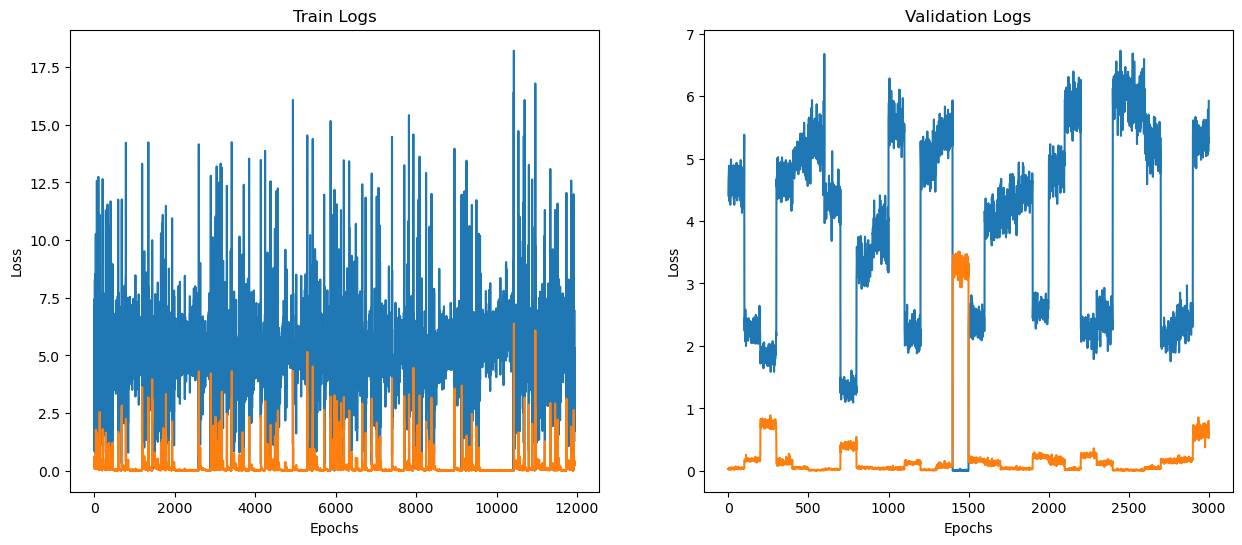

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Train Logs
axes[0].plot(train["G_losses"])
axes[0].plot(train["D_losses"])
axes[0].set_title("Train Logs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

# Plot for Validation Logs
axes[1].plot(val["G_losses"])
axes[1].plot(val["D_losses"])
axes[1].set_title("Validation Logs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

plt.show()

<h1>| Test the Generator</h1>

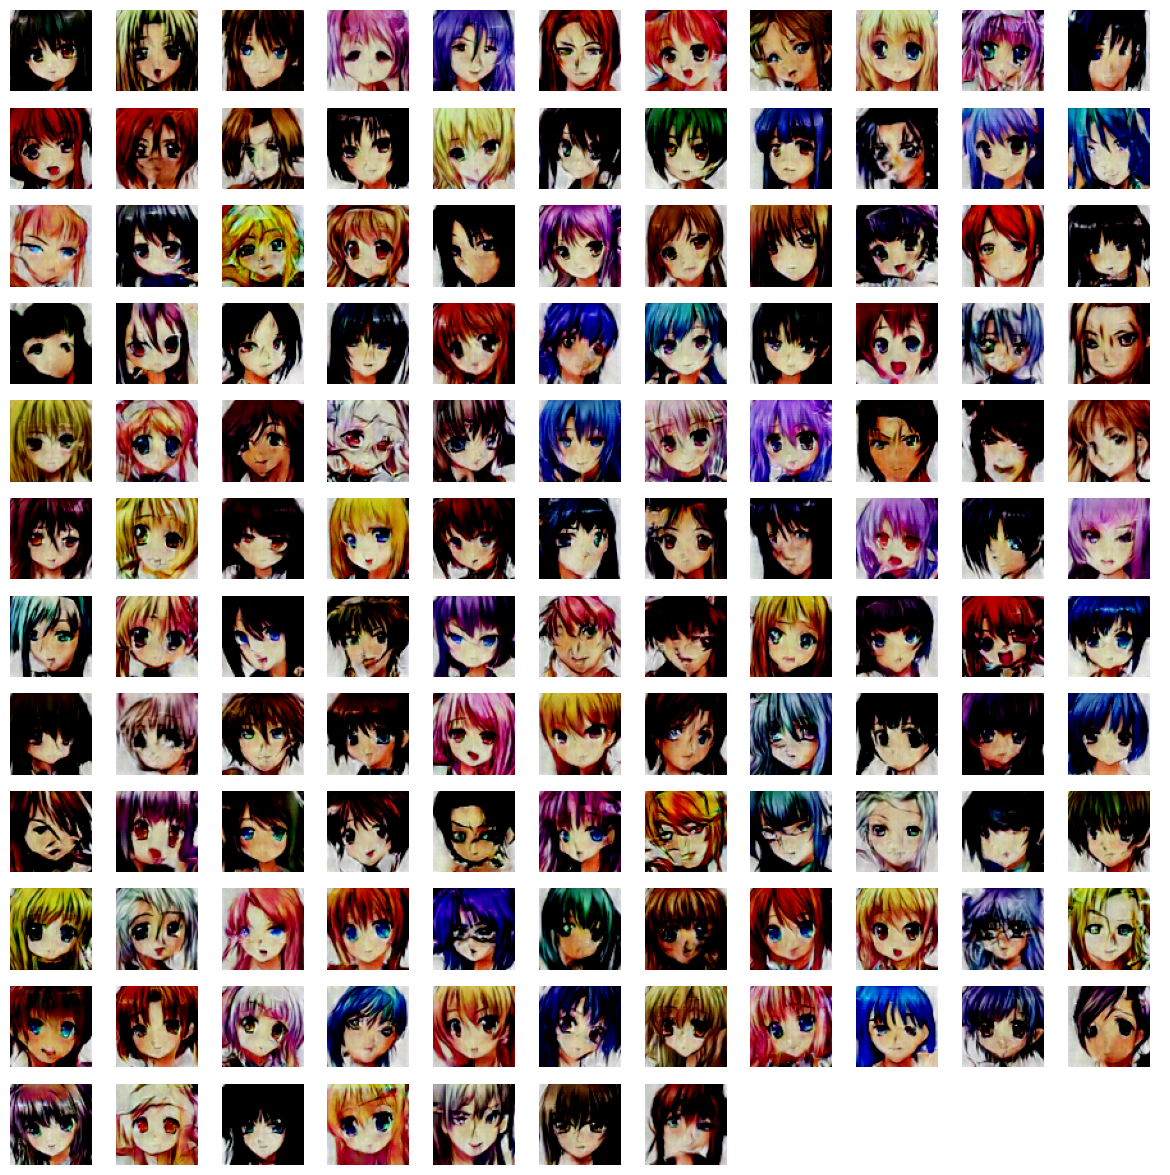

In [32]:
def generated_image_plot(fake_data, title="Generated Images Grid"):
    batch_size, channels, height, width = fake_data.shape

    num_rows = int(np.ceil(np.sqrt(batch_size)))
    num_cols = int(np.ceil(batch_size / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(batch_size):
        img = fake_data[i].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.axis("off")

    for i in range(batch_size, num_rows * num_cols):
        axes.flatten()[i].axis("off")

    plt.subplots_adjust(wspace=0.01)

    plt.show()
    batch_size, channels, height, width = fake_data.shape

fake_data = netG(fixed_noise)
generated_image_plot(fake_data)

<h1>| Conclusion</h1>
<p style="font-size: 17px">The model performs quite well, but can be drastically improvised. From the graphs, we can see that the the gap between the <b>G_Loss</b> and <b>D_Loss</b> on Validation is bit far apart and hence it has to be brought closer. <br />
    Do 🍴 the notebook and ⬆️ it if you ❤️ it.</p>